In [3]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, train_final_model, plot_confusion_matrices, plot_roc_curves, plot_losses
from model import predict
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing
## Assign labels

In [4]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [5]:
df.duplicated().sum()

np.int64(307)

In [6]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [7]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [8]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [10]:
categorical_unique = preprocessing.unique(df, categorical_columns)
numeric_unique = preprocessing.unique(df, numeric_columns)

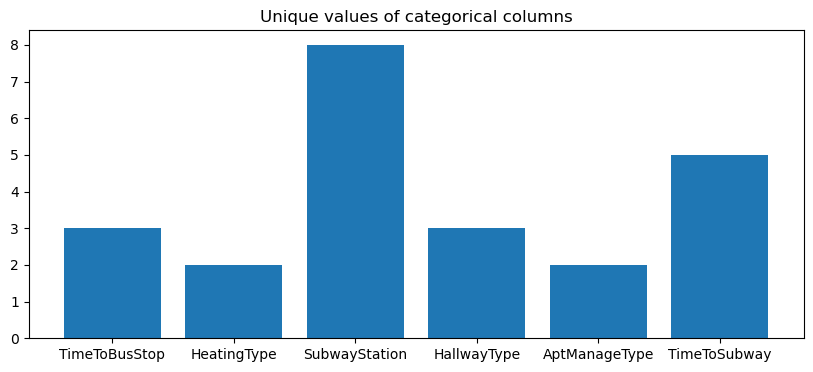

In [11]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [12]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [13]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

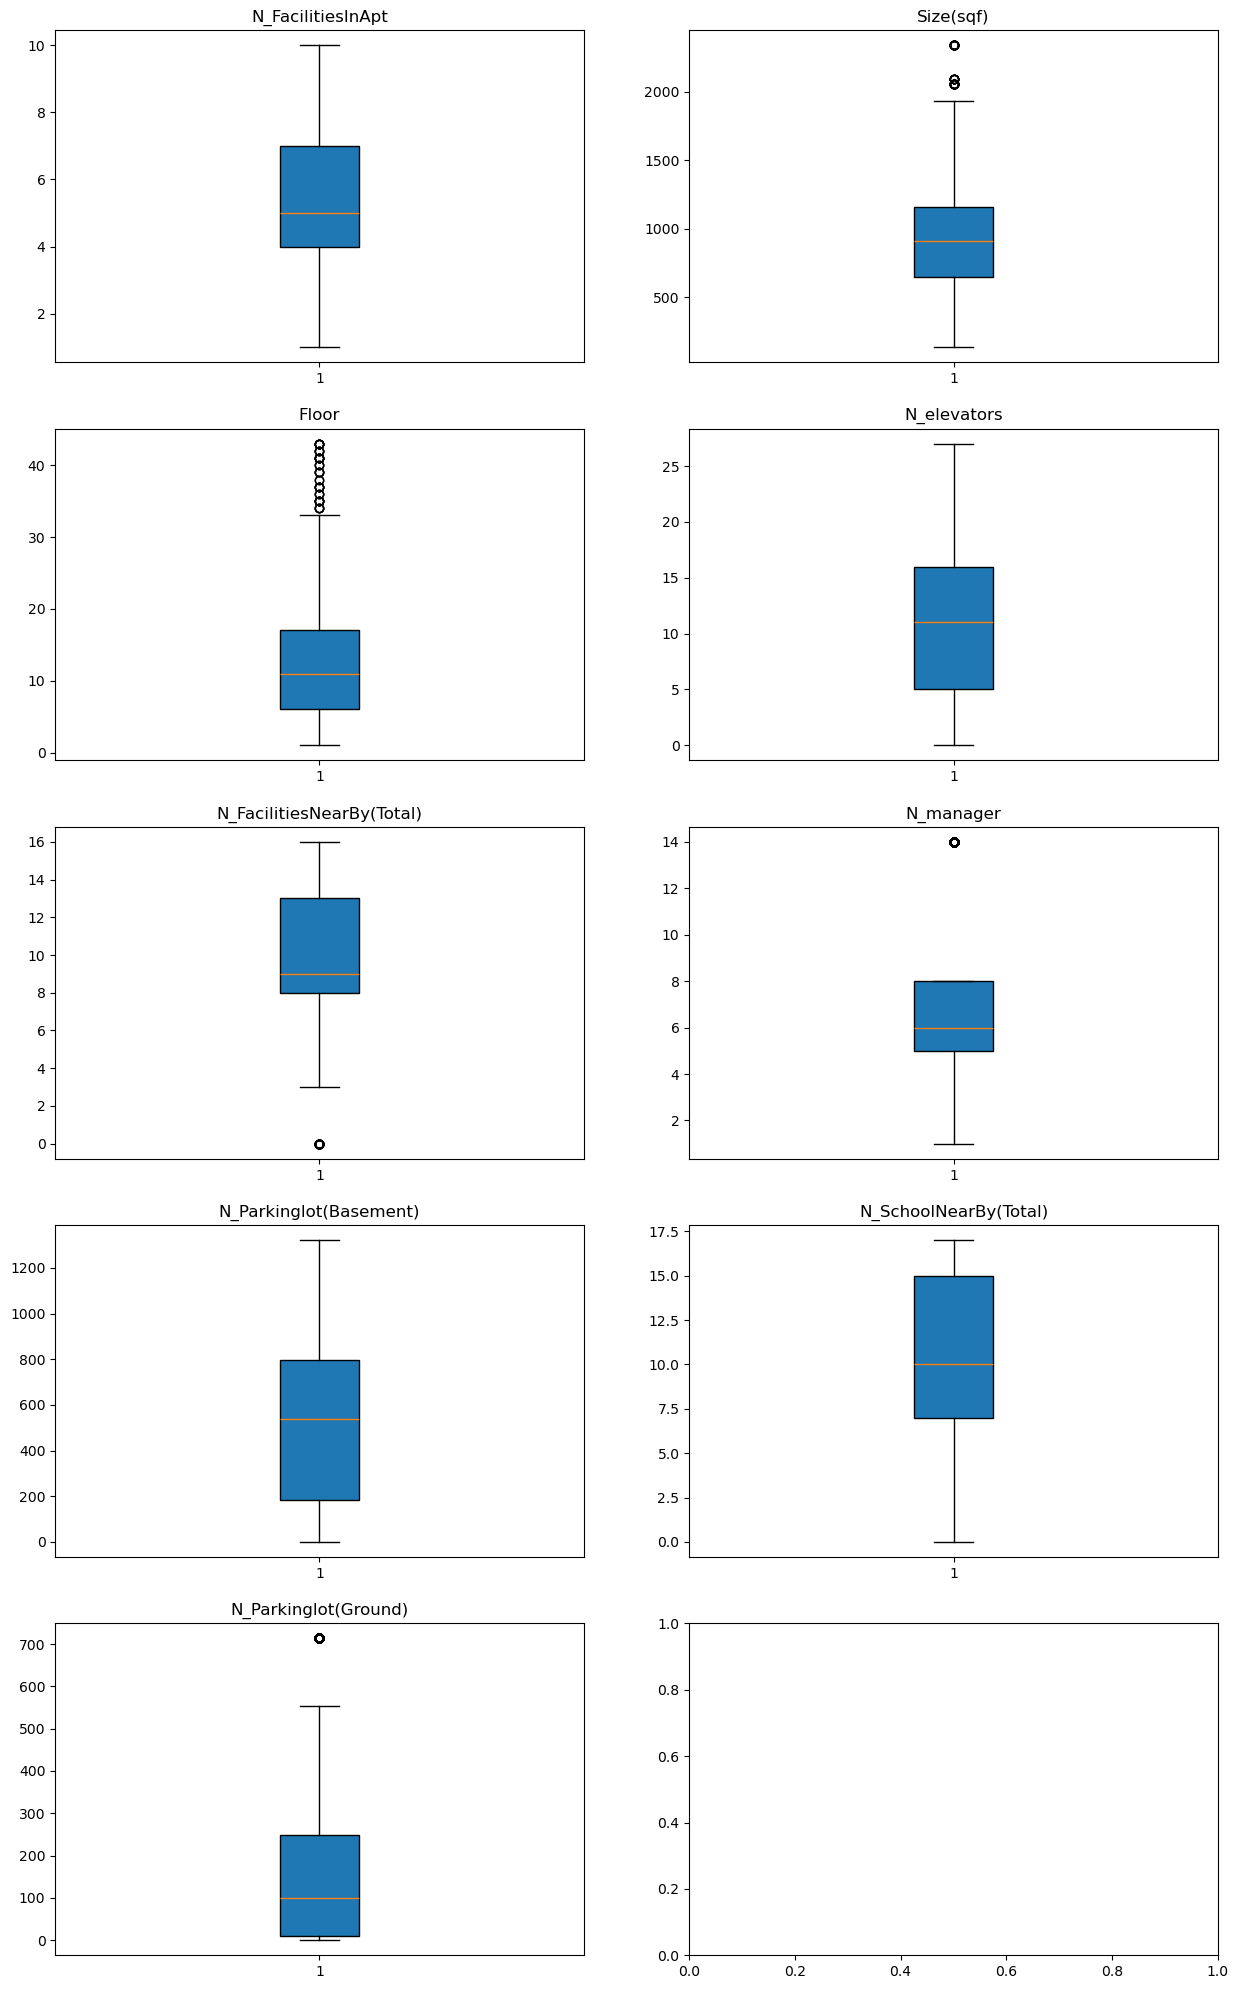

In [15]:
preprocessing.plot_boxplot(df, numeric_columns)

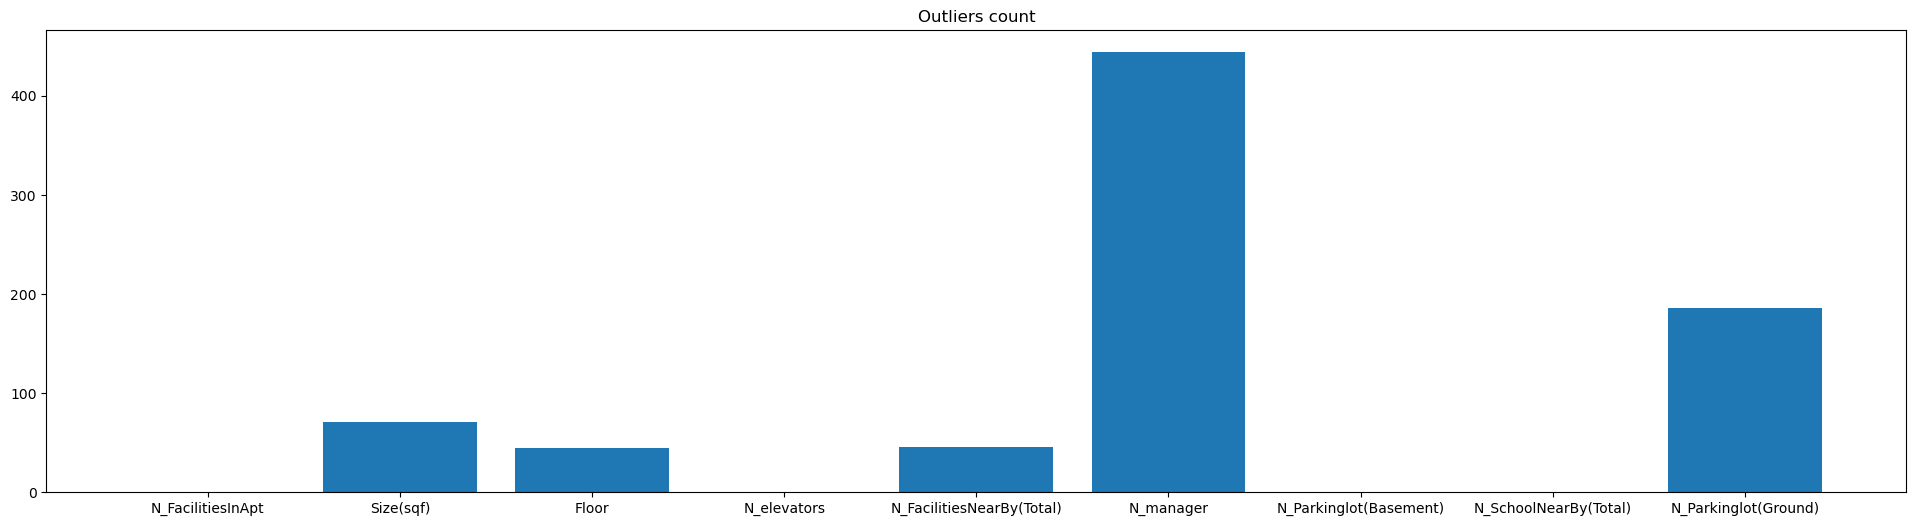

In [16]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

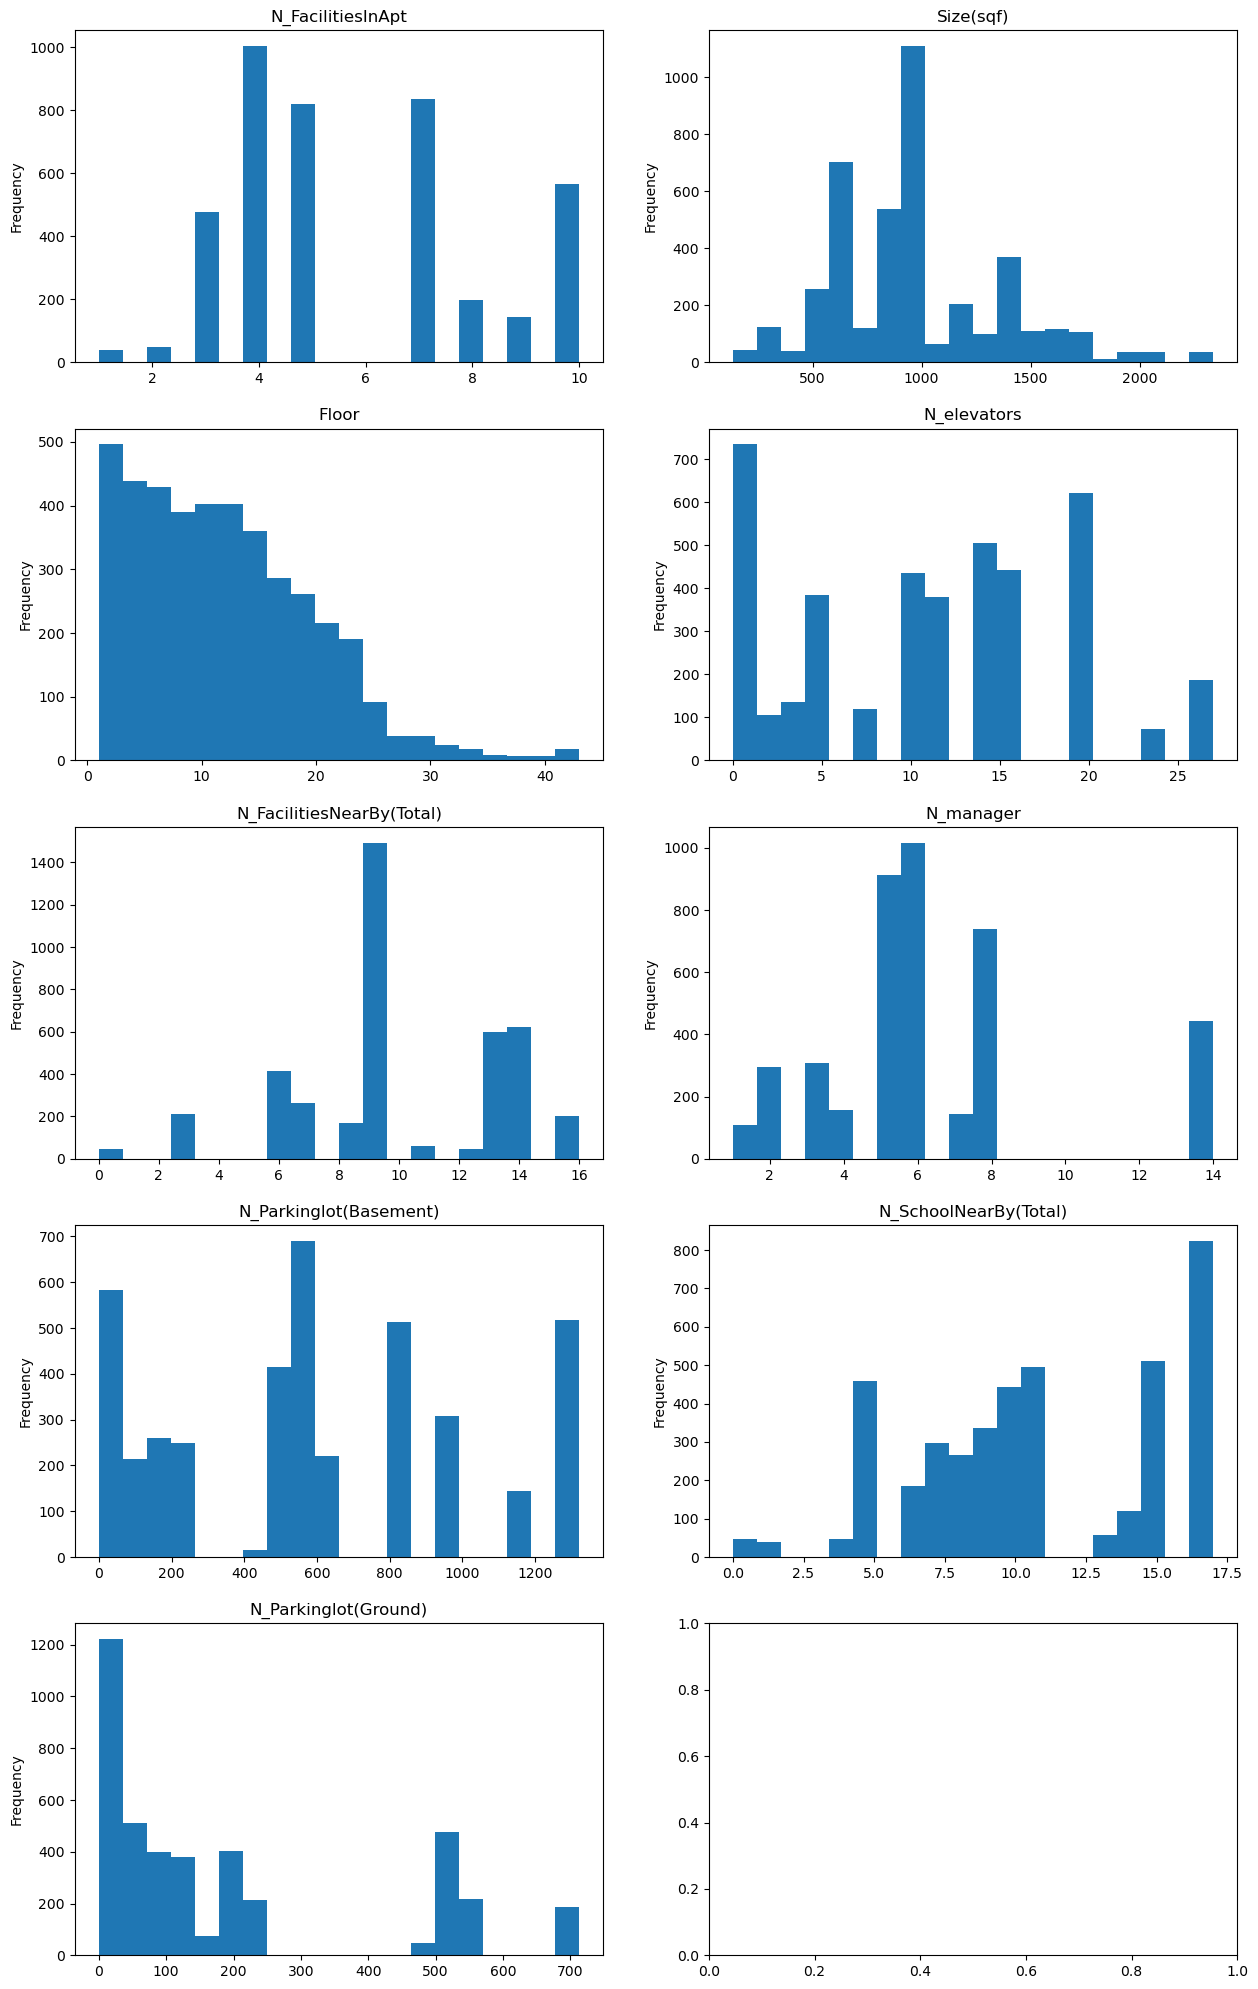

In [17]:
preprocessing.plot_histograms(df, numeric_columns)

In [18]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'N_FacilitiesInApt': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'Floor': 'not normally distributed',
 'N_elevators': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_manager': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed'}

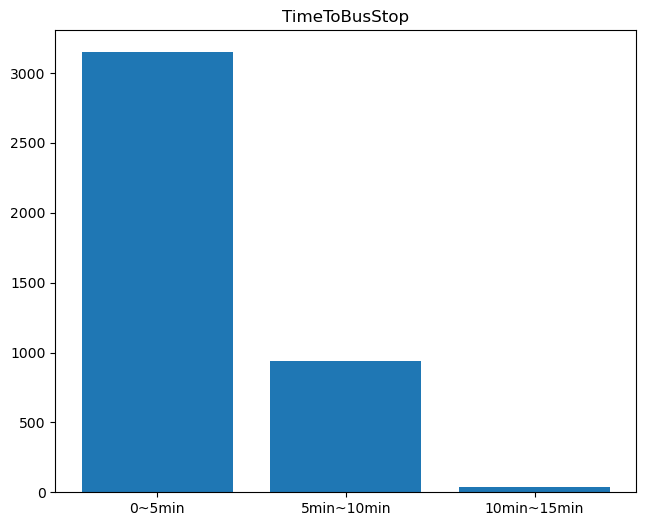

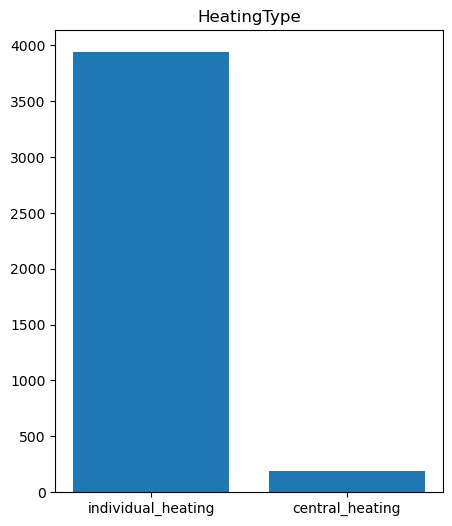

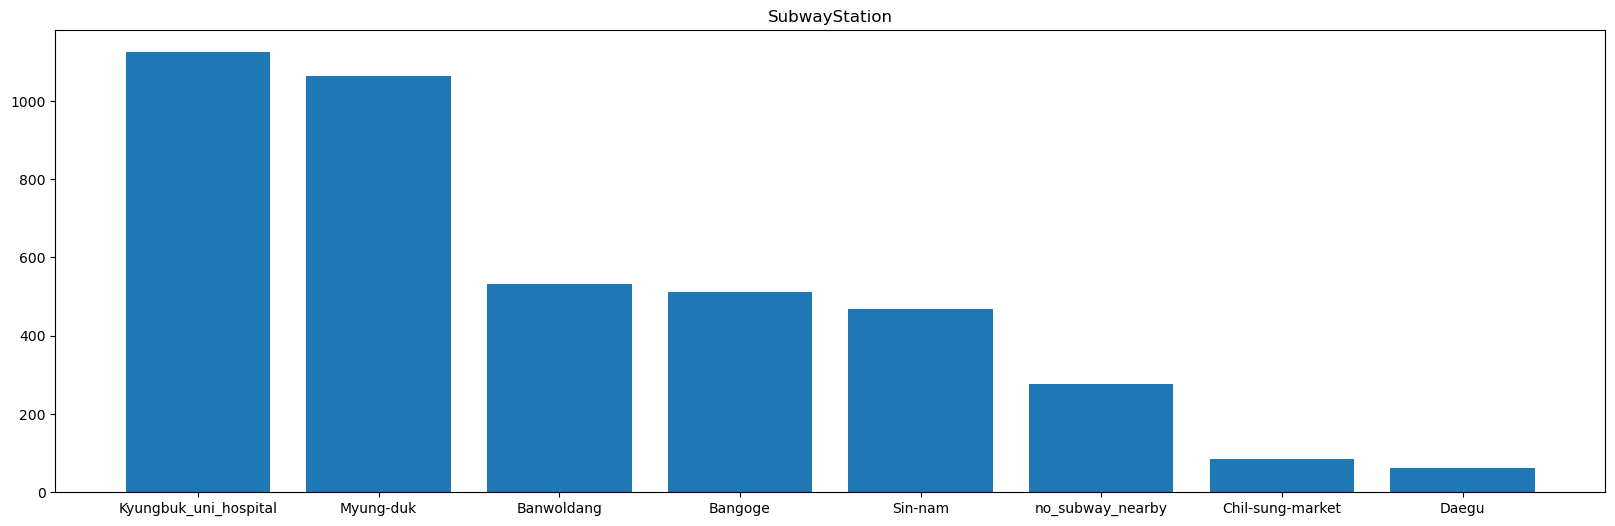

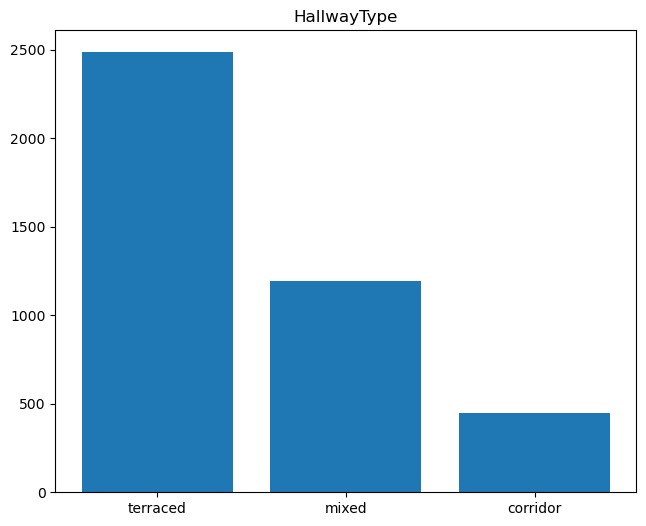

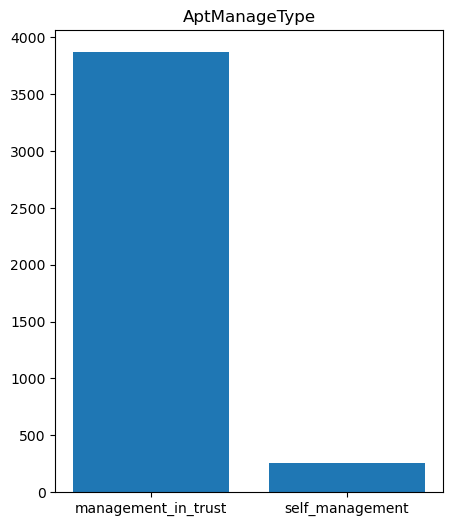

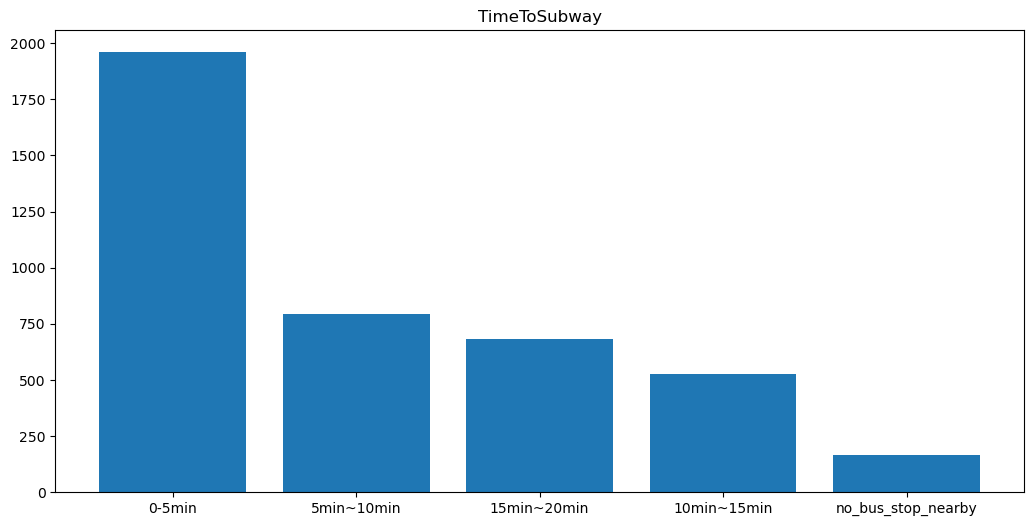

In [19]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

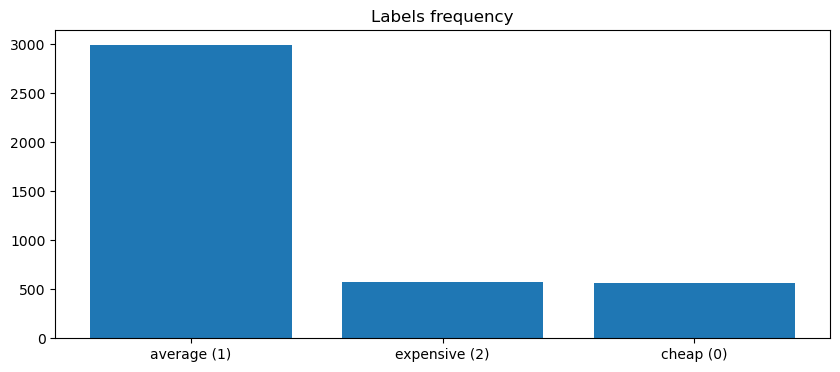

In [20]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [21]:
X = df.drop(columns=["Label"])
y = df["Label"]
X, y = preprocessing.preprocess(X, numeric_columns, ordinal_columns, nominal_columns, y=y, oversample=True, undersample=False, random_state=42, echo_ordinal_counts=True)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

TimeToBusStop value counts:
TimeToBusStop
0~5min         6649
5min~10min     2127
10min~15min     200
Name: count, dtype: int64
ordinal__TimeToBusStop value counts:
ordinal__TimeToBusStop
0.0    6649
1.0    2127
2.0     200
Name: count, dtype: int64
TimeToSubway value counts:
TimeToSubway
0-5min                4160
5min~10min            2064
15min~20min           1349
10min~15min           1238
no_bus_stop_nearby     165
Name: count, dtype: int64
ordinal__TimeToSubway value counts:
ordinal__TimeToSubway
0.0    4160
1.0    2064
3.0    1349
2.0    1238
4.0     165
Name: count, dtype: int64


In [22]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([1.0014, 1.0069, 0.9918])

# Model and training

In [23]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 1.007217321775656
Epoch: 1, loss: 0.607853259396764
Epoch: 2, loss: 0.5199932550961992
Epoch: 3, loss: 0.47283094910393775
Epoch: 4, loss: 0.4435251360445951
Epoch: 5, loss: 0.42376913354460116
Epoch: 6, loss: 0.40189565757734586
Epoch: 7, loss: 0.3835143636813206
Epoch: 8, loss: 0.37249414279925086
Epoch: 9, loss: 0.36040930384028275
Epoch: 10, loss: 0.3549080492384666
Epoch: 11, loss: 0.3439180225925108
Epoch: 12, loss: 0.3351673466705643
Epoch: 13, loss: 0.33315723659717933
Epoch: 14, loss: 0.32786594581814993
Epoch: 15, loss: 0.32429707300873983
Epoch: 16, loss: 0.3200418897698411
Epoch: 17, loss: 0.31289985815508176
Epoch: 18, loss: 0.3118132735248161
Epoch: 19, loss: 0.3091654163018792
Epoch: 20, loss: 0.30488196938438755
Epoch: 21, loss: 0.30392542705599185
Epoch: 22, loss: 0.3042353353405421
Epoch: 23, loss: 0.30129044232642754
Epoch: 24, loss: 0.3017321810521911
Epoch: 25, loss: 0.3009520654393508
Epoch: 26, loss: 0.2963745410727189
Epoch: 27, 

In [24]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.893175,0.893175,0.893175,0.893175,0.895323,0.895323,0.895323,0.895323
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.894568,0.894568,0.894568,0.894568,0.898664,0.898664,0.898664,0.898664
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.892618,0.892618,0.892618,0.892618,0.893096,0.893096,0.893096,0.893096
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.883148,0.883148,0.883148,0.883148,0.894766,0.894766,0.894766,0.894766
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.890251,0.890251,0.890251,0.890251,0.898664,0.898664,0.898664,0.898664
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.888162,0.888162,0.888162,0.888162,0.899220,0.899220,0.899220,0.899220


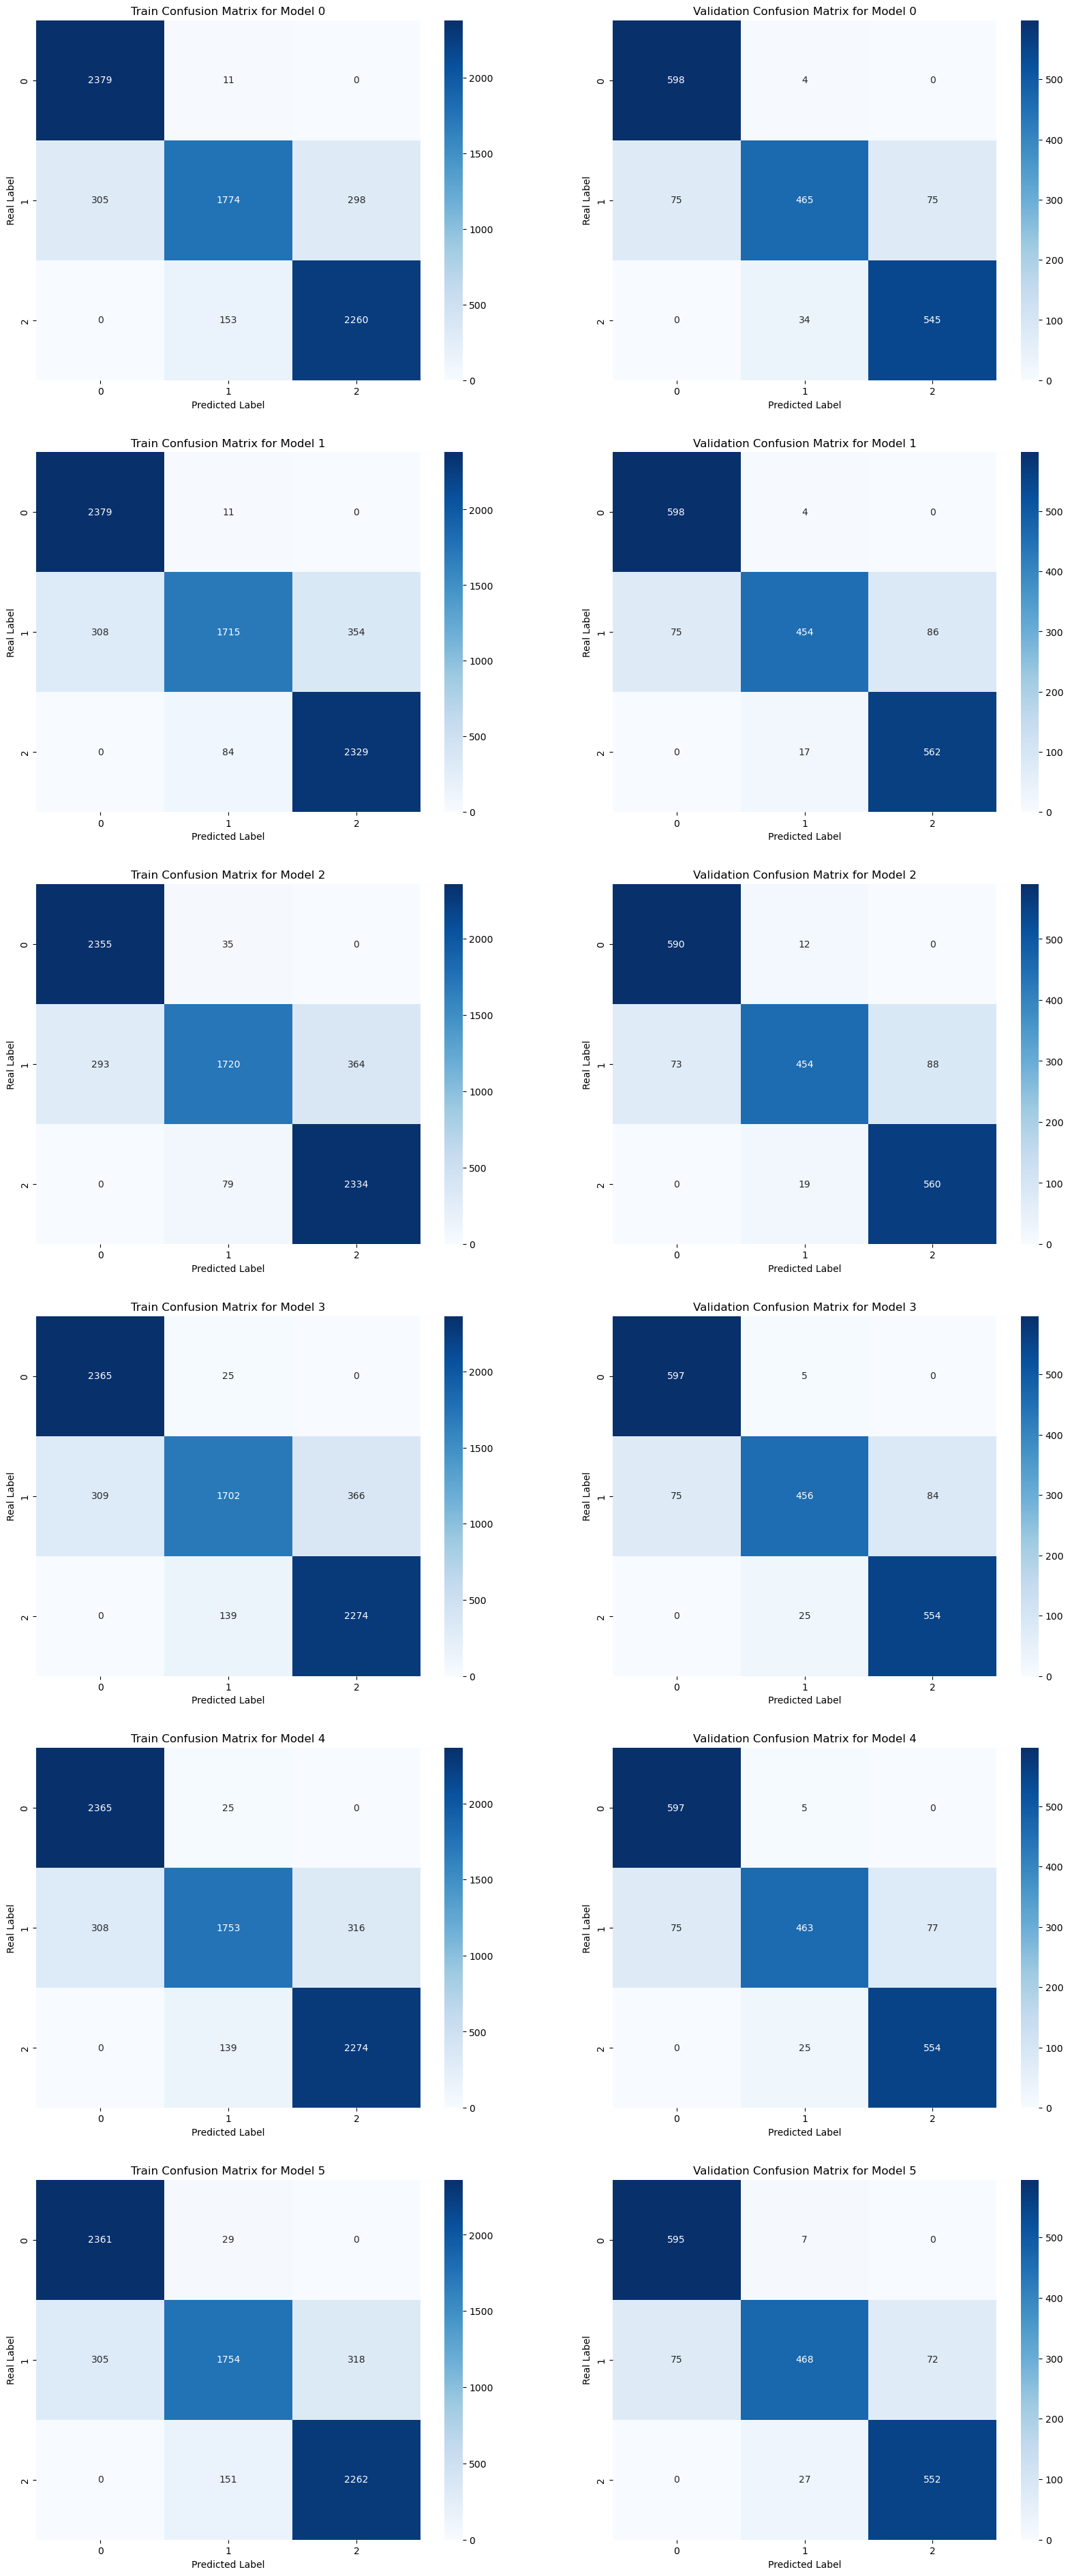

In [25]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

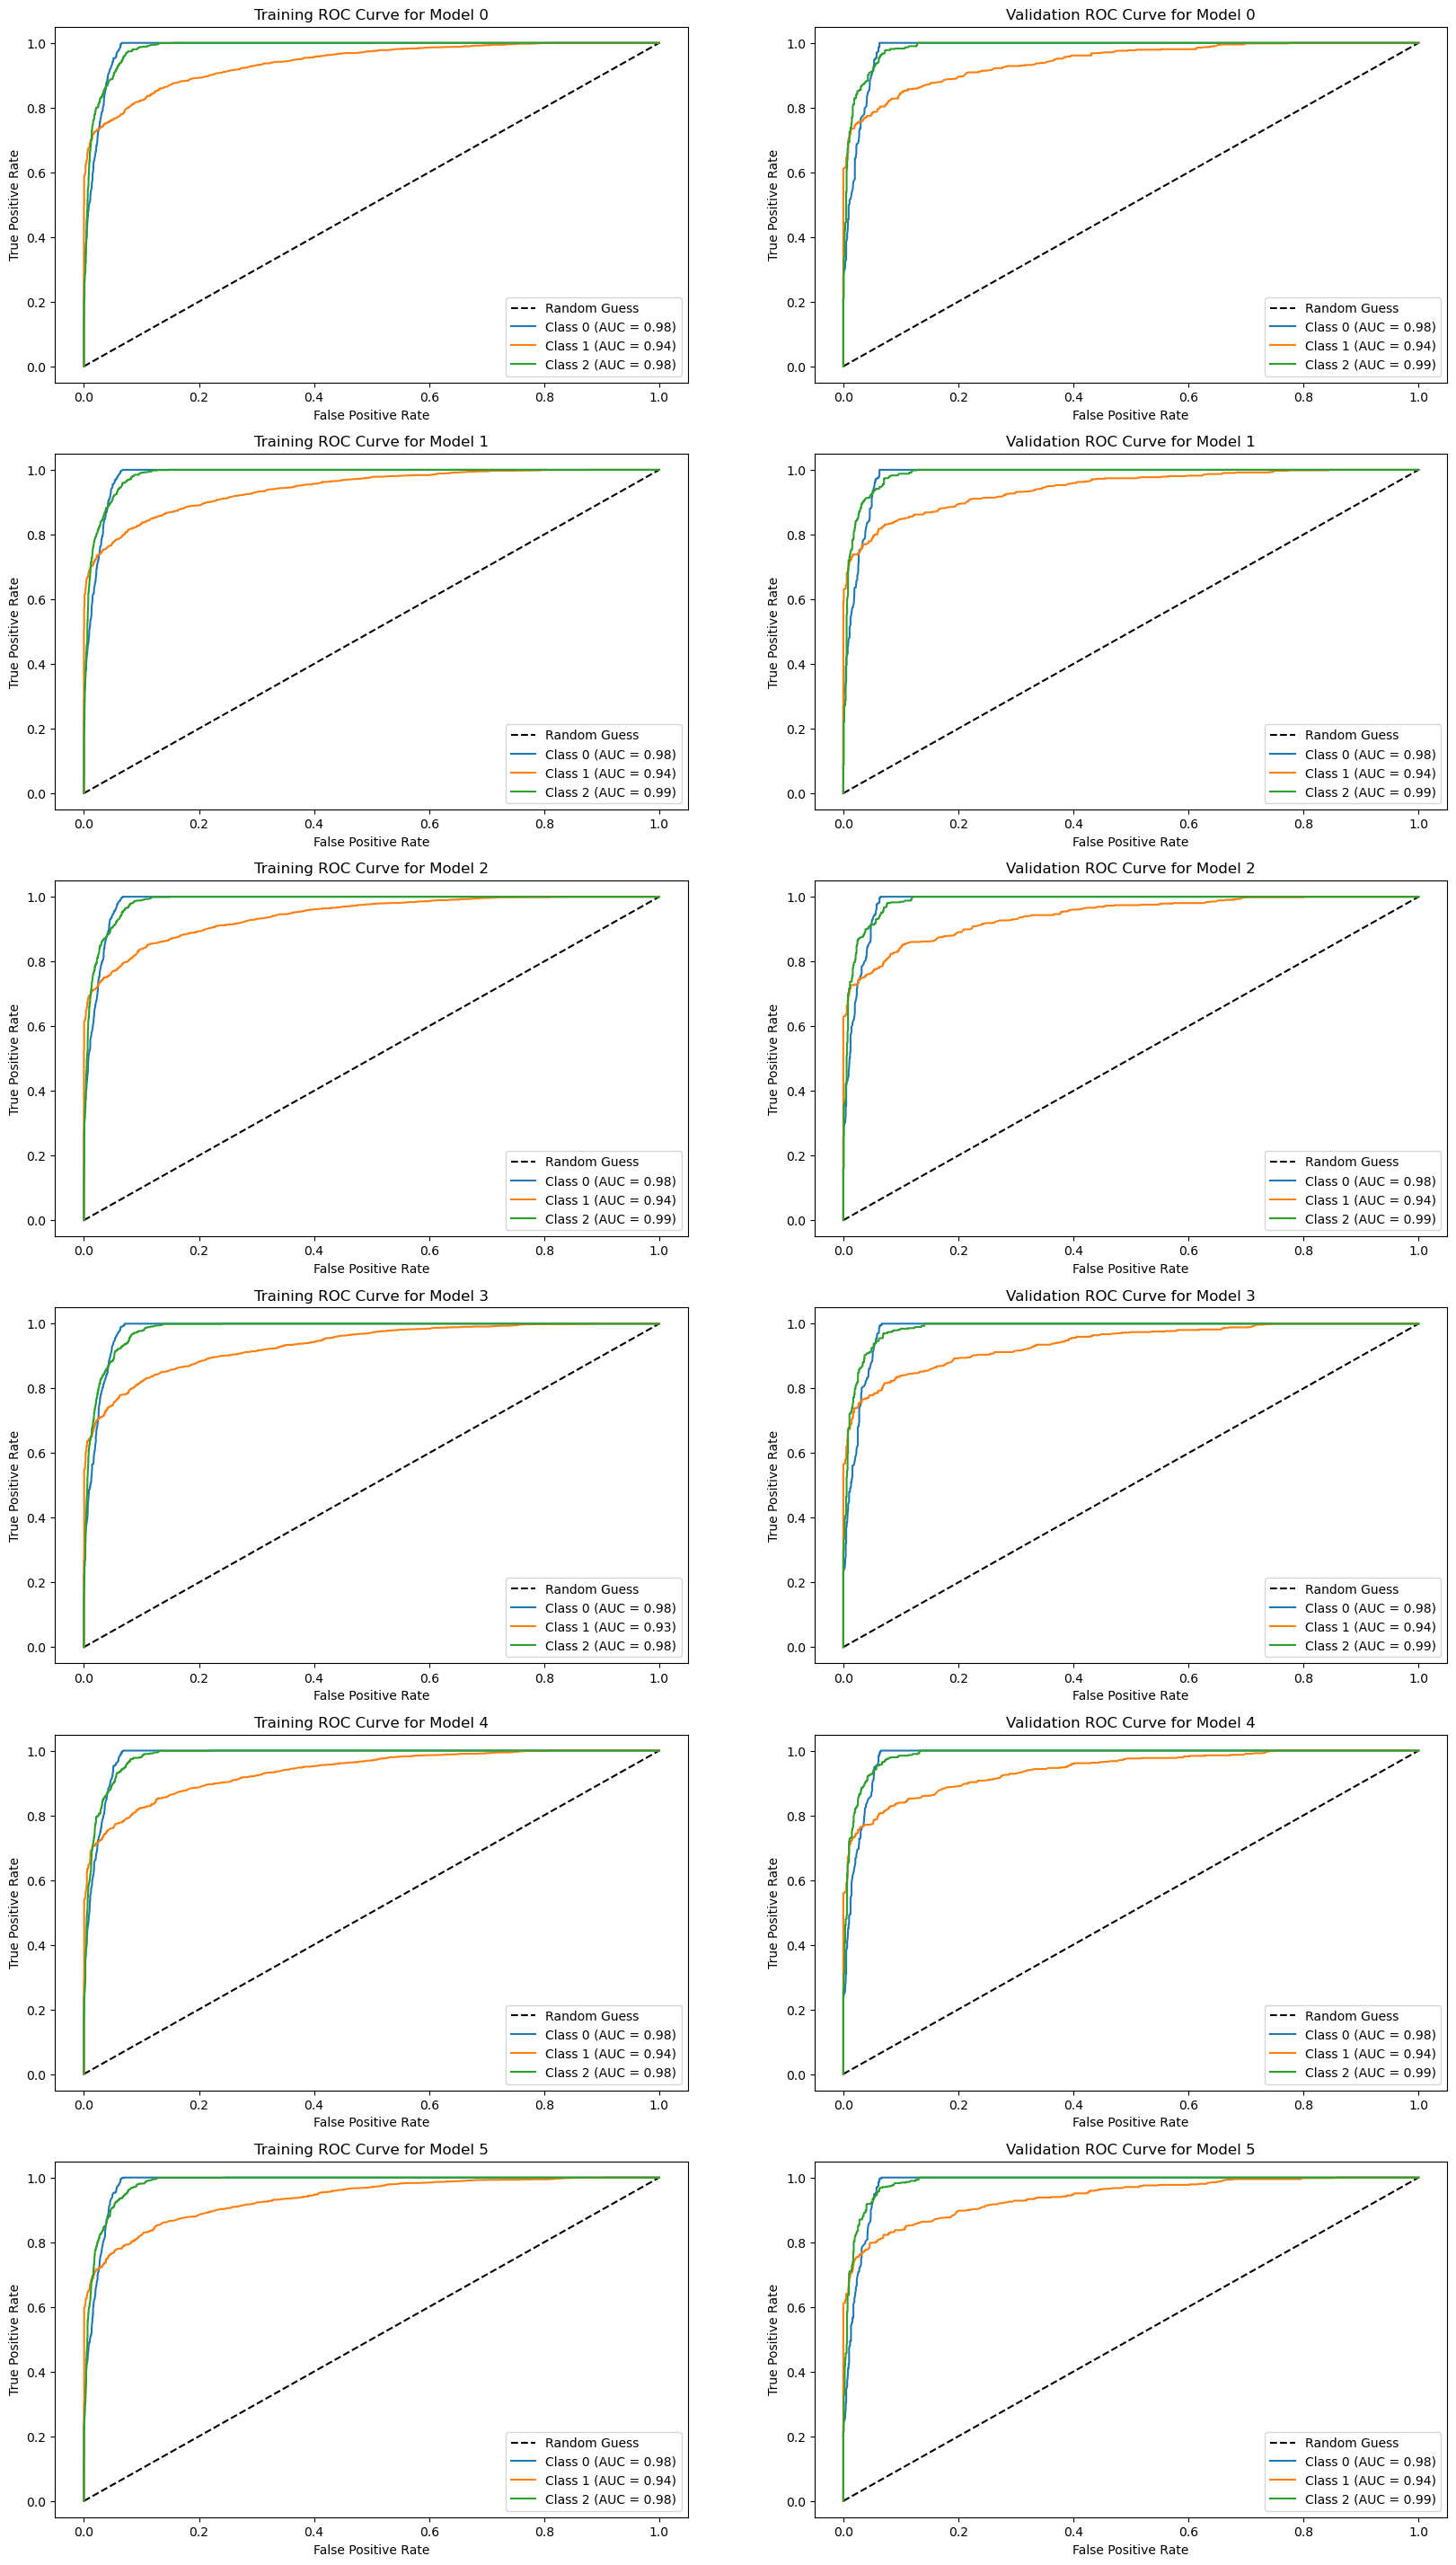

In [26]:
plot_roc_curves(train_roc_curve, val_roc_curve)

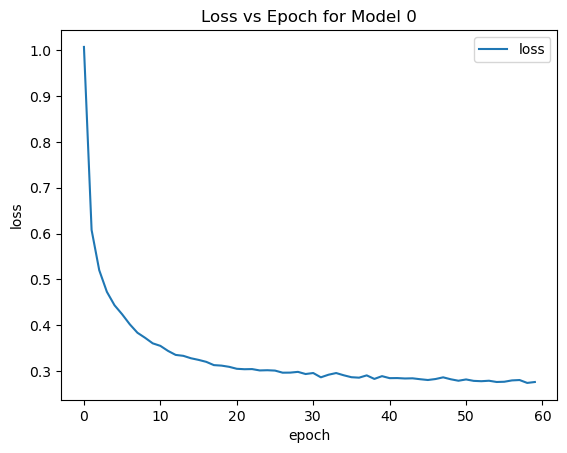

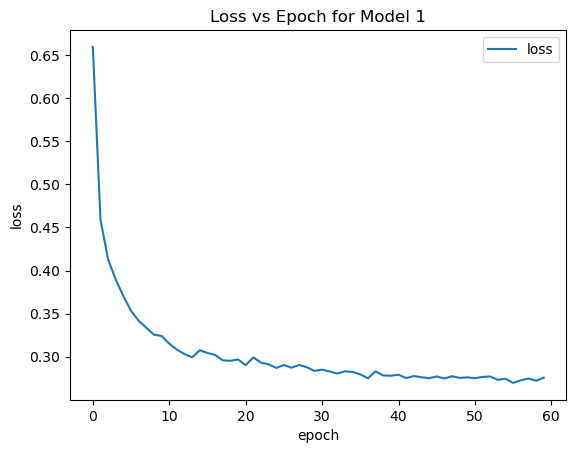

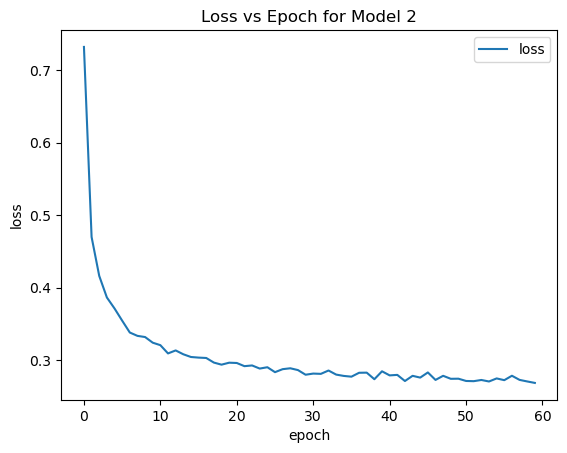

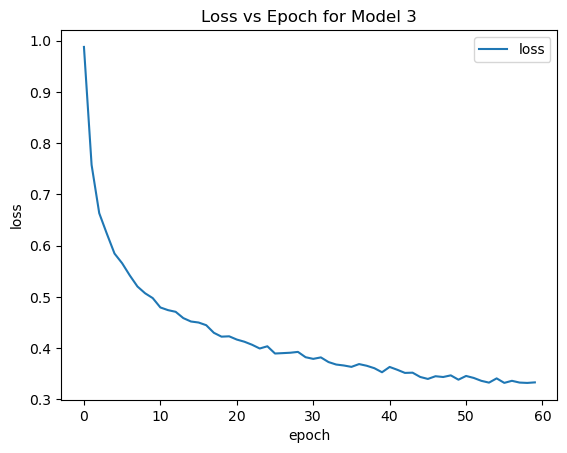

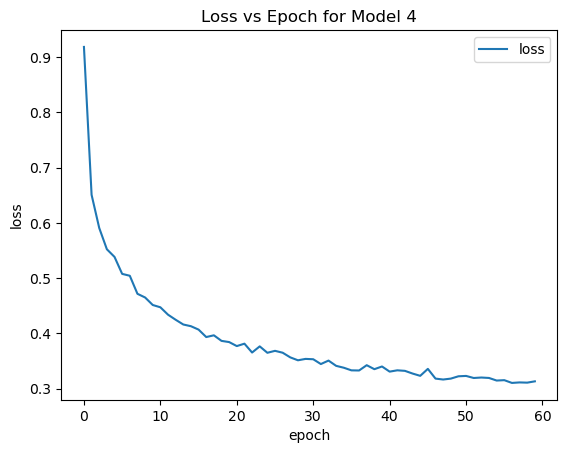

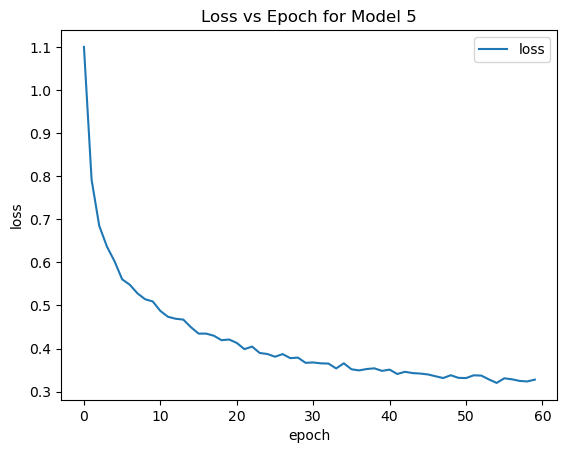

In [27]:
plot_losses(losses)

In [33]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[5], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.5302465391897522
Epoch: 1, loss: 0.4119613227327313
Epoch: 2, loss: 0.38630739526938546
Epoch: 3, loss: 0.38551474685690046
Epoch: 4, loss: 0.37298873277892053
Epoch: 5, loss: 0.3549942419064783
Epoch: 6, loss: 0.3472315791038285
Epoch: 7, loss: 0.34639745317729176
Epoch: 8, loss: 0.3395935713717368
Epoch: 9, loss: 0.3288472538764498
Epoch: 10, loss: 0.3392657380452198
Epoch: 11, loss: 0.32918827868668377
Epoch: 12, loss: 0.36826629963068835
Epoch: 13, loss: 0.3342442614051093
Epoch: 14, loss: 0.34192225482084054
Epoch: 15, loss: 0.33250855186344247
Epoch: 16, loss: 0.3241564350581802
Epoch: 17, loss: 0.33232265499840796
Epoch: 18, loss: 0.3332861597295356
Epoch: 19, loss: 0.32426354631913445
Epoch: 20, loss: 0.32252821062518433
Epoch: 21, loss: 0.31758050422752854
Epoch: 22, loss: 0.32066778113356736
Epoch: 23, loss: 0.32412138990068856
Epoch: 24, loss: 0.3183170124492814
Epoch: 25, loss: 0.3308963536952449
Epoch: 26, loss: 0.32115501547809194
Epoch:

In [35]:
hyperparameters_results = pd.DataFrame({"models": [architectures[5]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.887047,0.887047,0.887047,0.887047,0.894209,0.894209,0.894209,0.894209
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.888301,0.888301,0.888301,0.888301,0.896437,0.896437,0.896437,0.896437
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.891086,0.891086,0.891086,0.891086,0.896993,0.896993,0.896993,0.896993
3,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.893175,0.893175,0.893175,0.893175,0.897550,0.897550,0.897550,0.897550
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.887744,0.887744,0.887744,0.887744,0.898107,0.898107,0.898107,0.898107
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.882869,0.882869,0.882869,0.882869,0.892539,0.892539,0.892539,0.892539
6,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.796518,0.796518,0.796518,0.796518,0.817372,0.817372,0.817372,0.817372
7,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.778134,0.778134,0.778134,0.778134,0.773942,0.773942,0.773942,0.773942


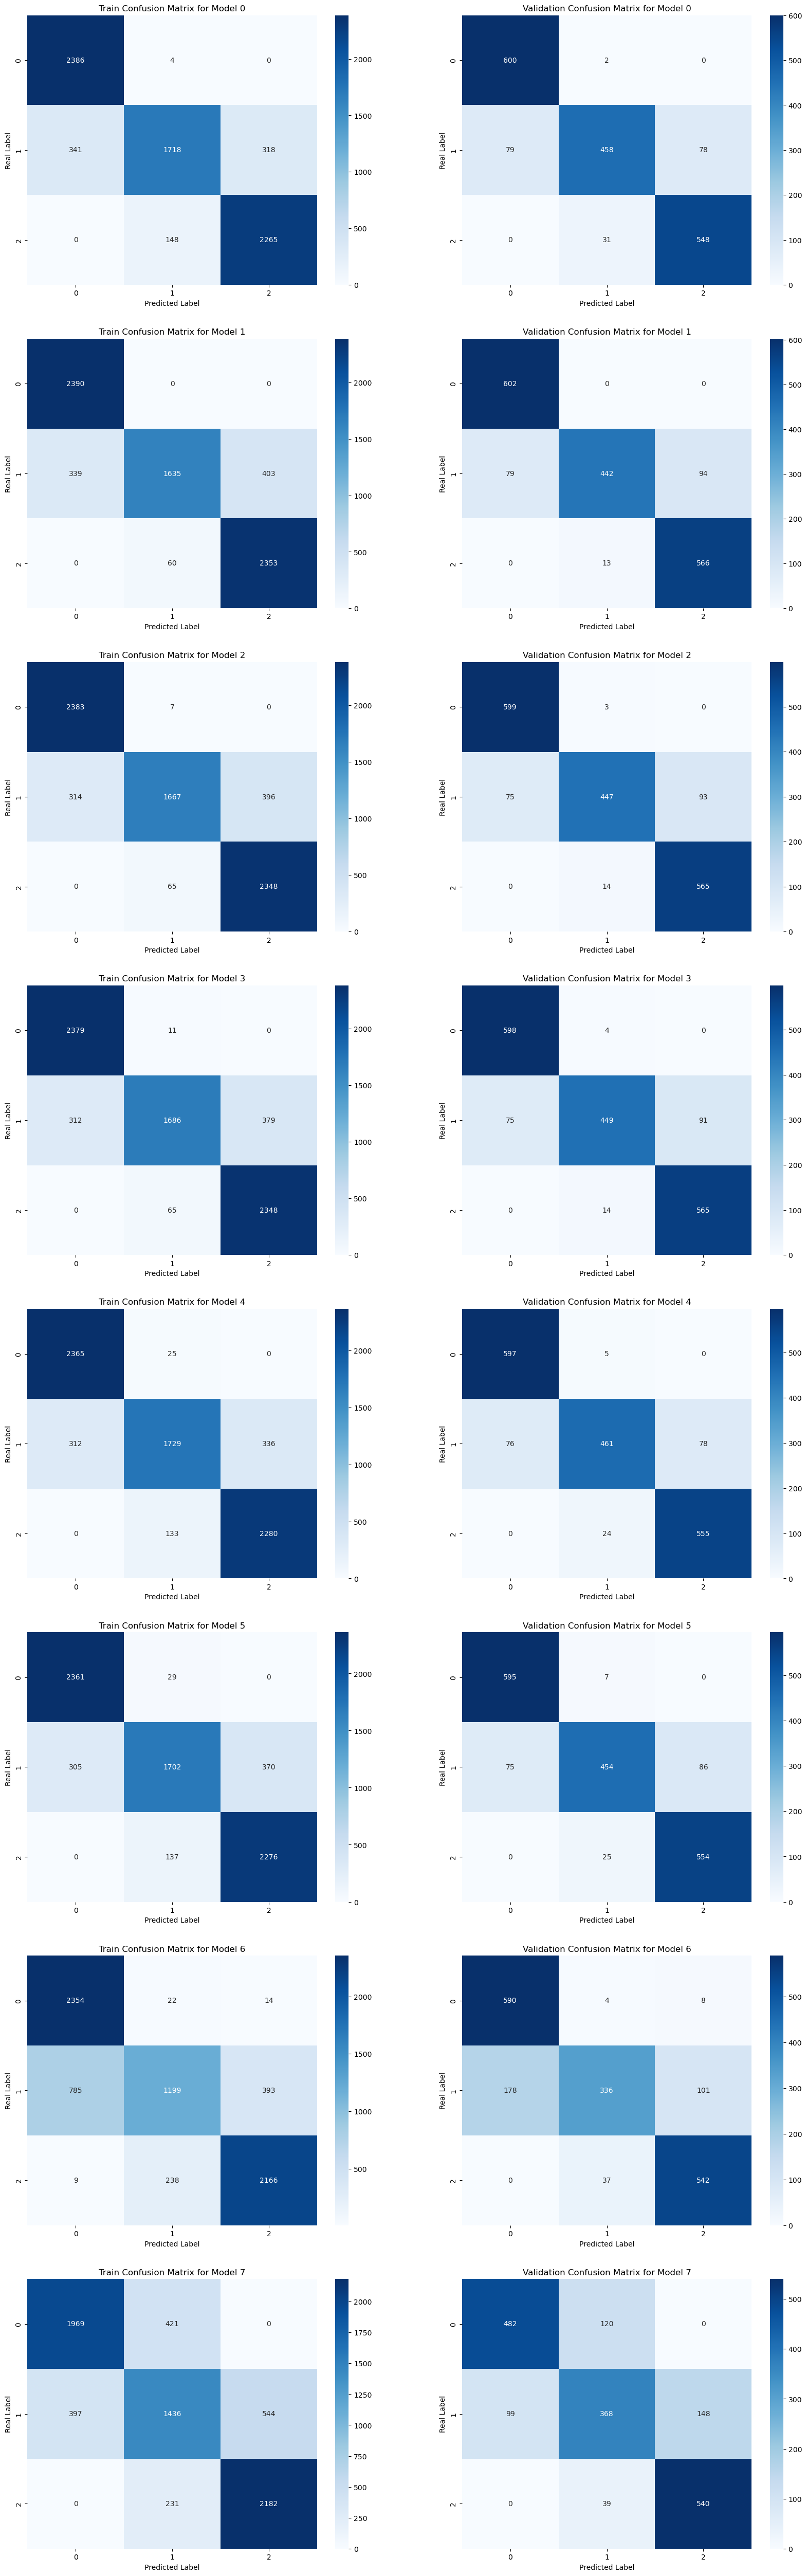

In [36]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

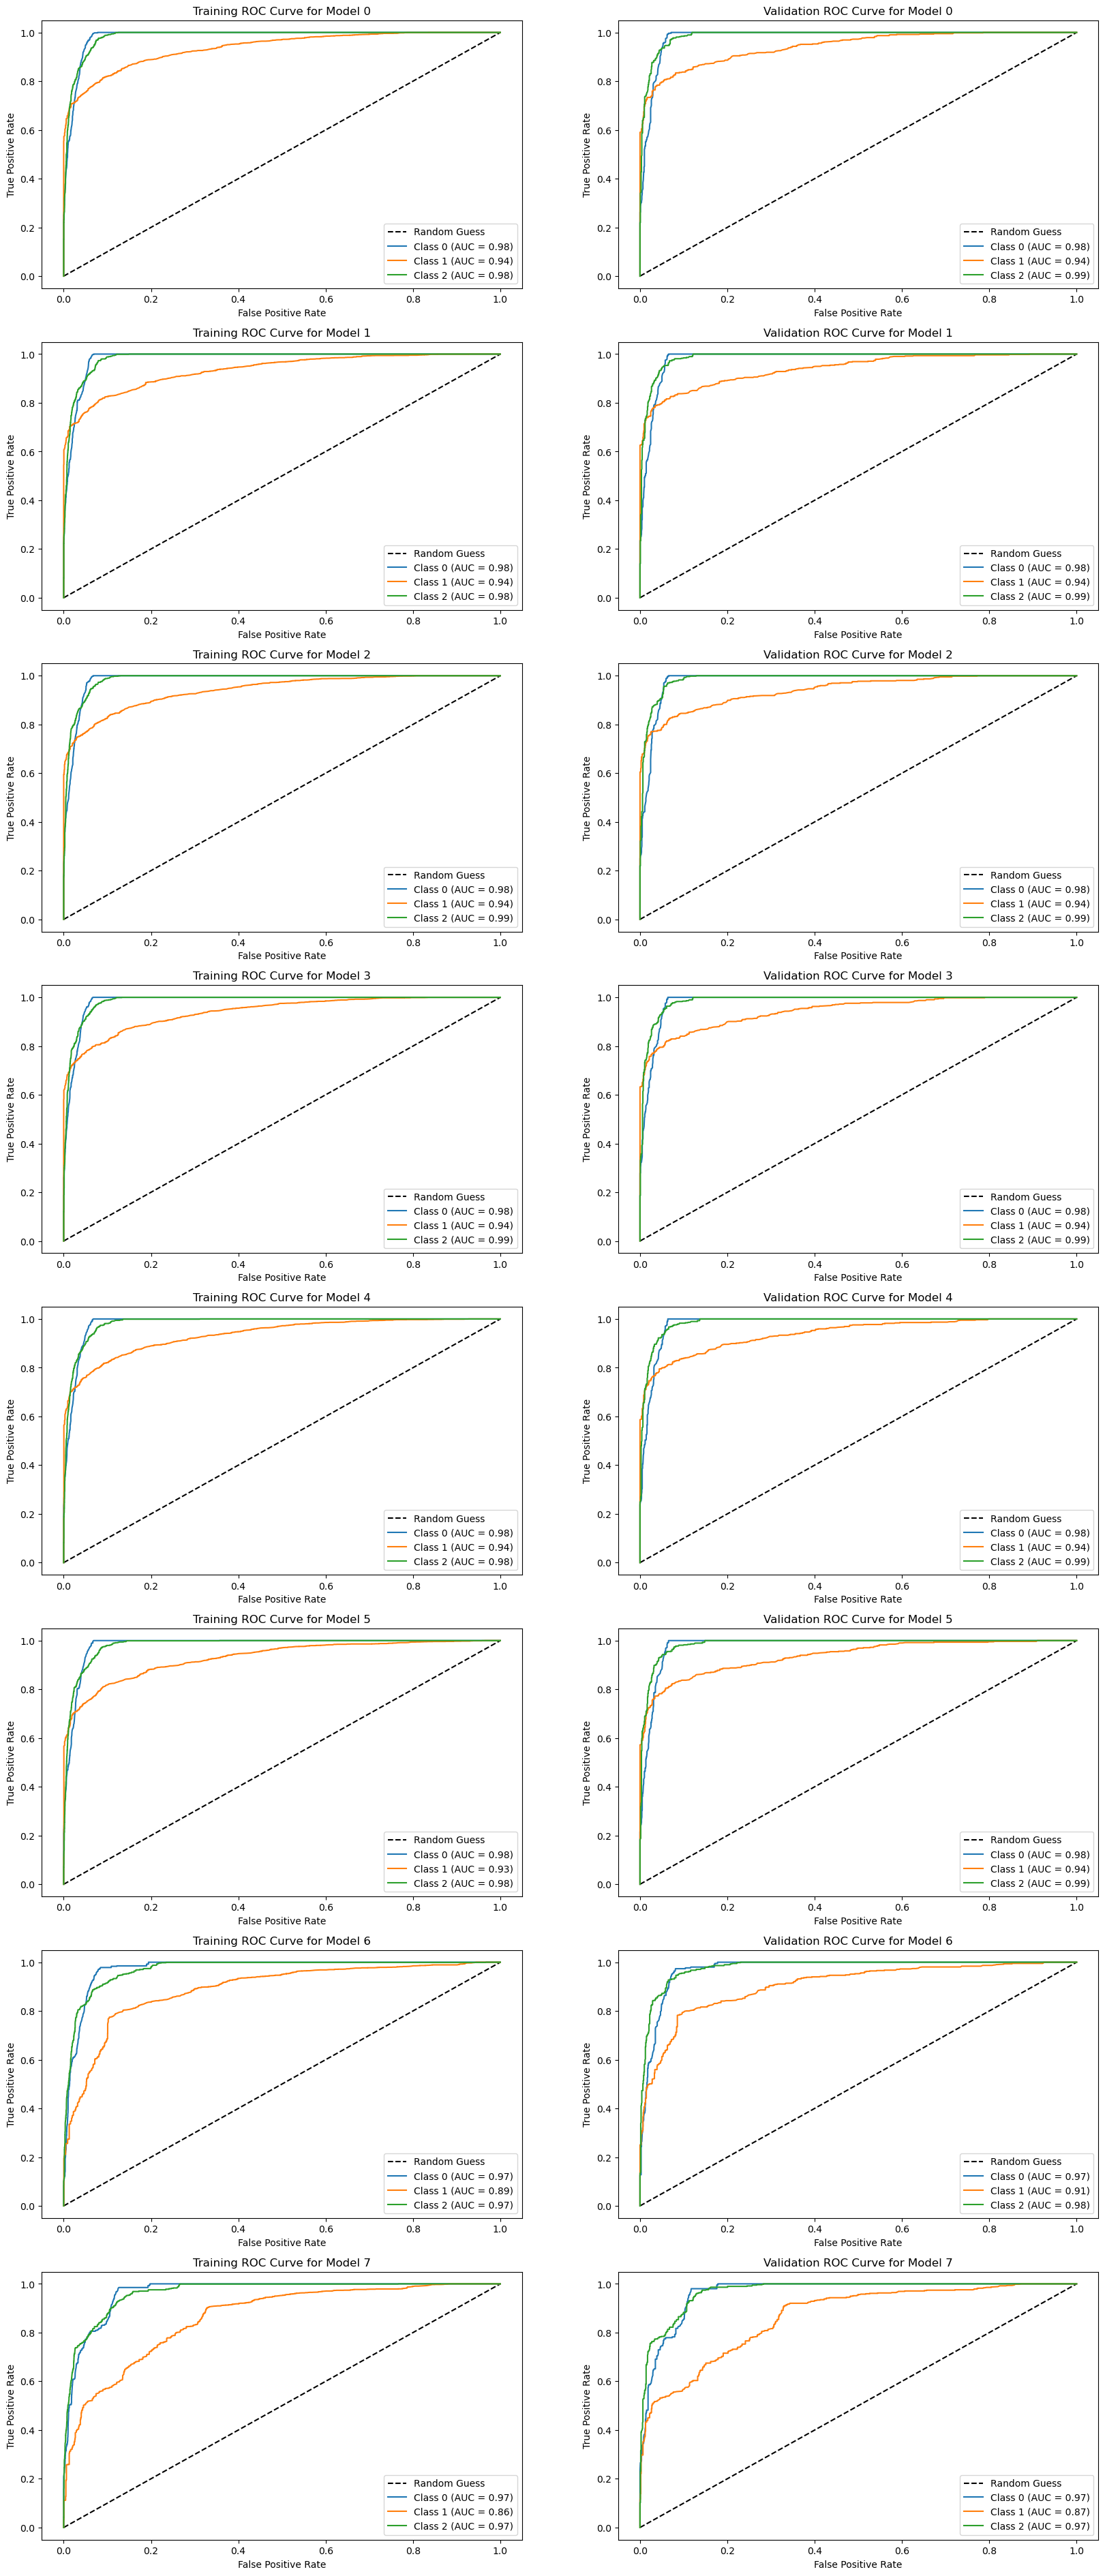

In [37]:
plot_roc_curves(train_roc_curve, val_roc_curve)

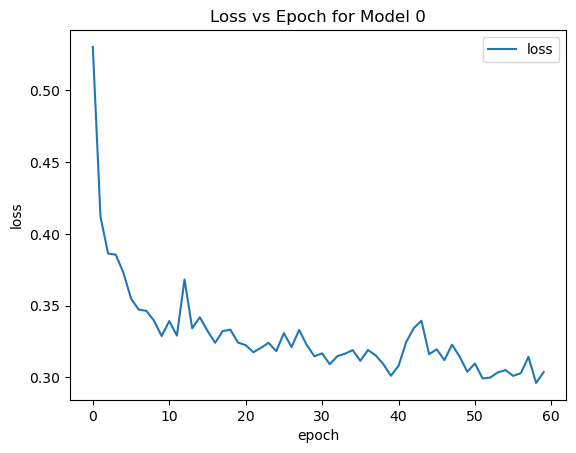

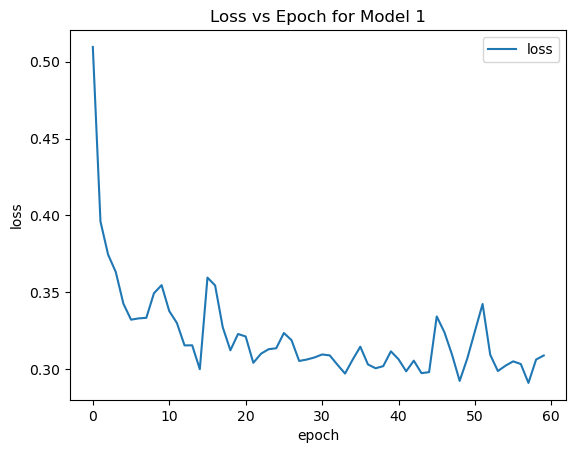

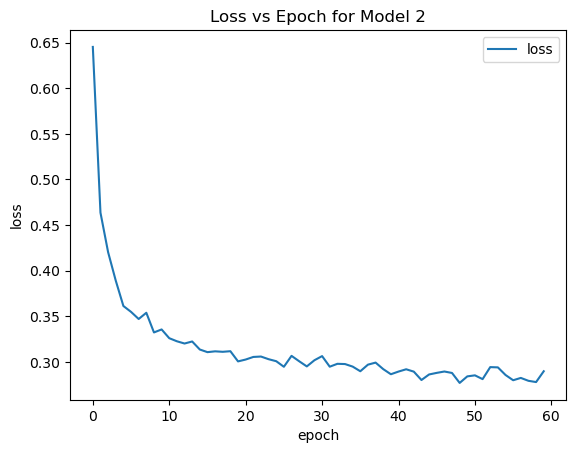

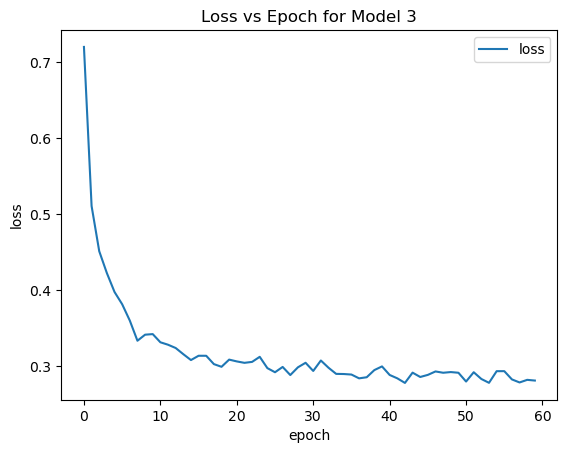

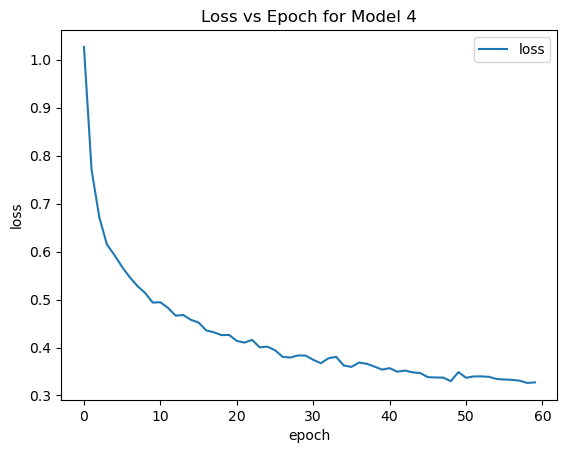

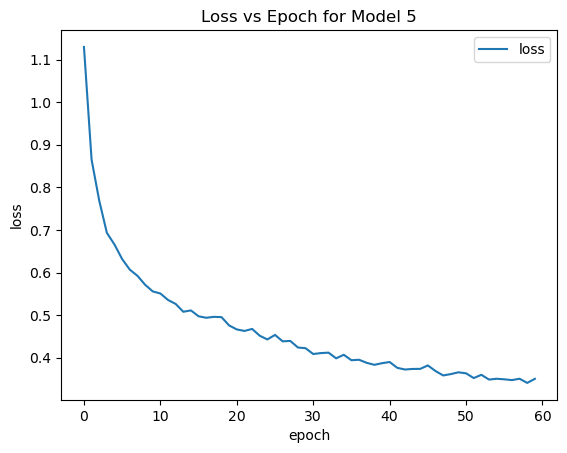

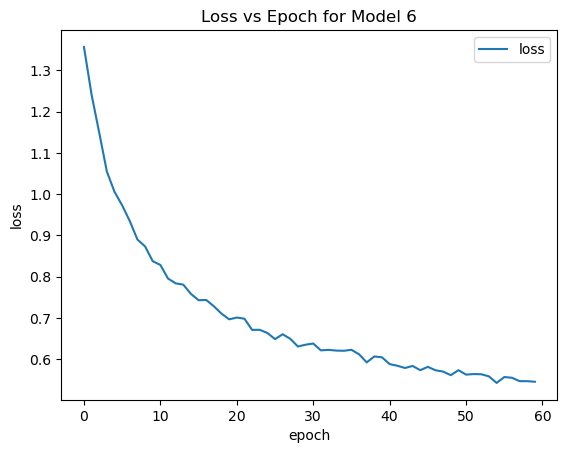

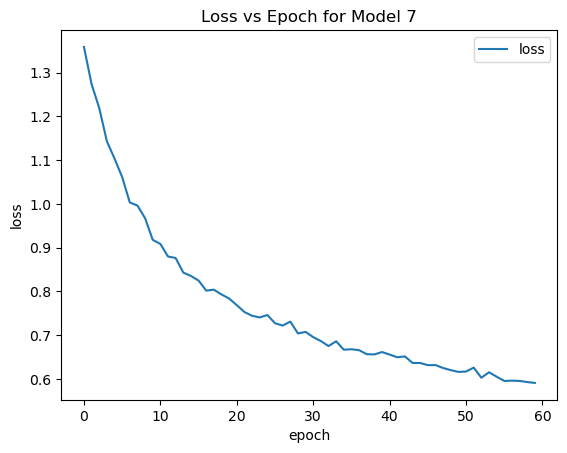

In [38]:
plot_losses(losses)

# Predict on test data

In [39]:
final_model = train_final_model(train_x, train_y, architectures[5], hyperparameters[4], device)

Training final model
Epoch: 0, loss: 1.14935213010923
Epoch: 1, loss: 0.7939490789333276
Epoch: 2, loss: 0.6909586217551105
Epoch: 3, loss: 0.6492101552739608
Epoch: 4, loss: 0.6053656242062561
Epoch: 5, loss: 0.5700237740457585
Epoch: 6, loss: 0.5591417543128528
Epoch: 7, loss: 0.5355576835902391
Epoch: 8, loss: 0.5191126130850969
Epoch: 9, loss: 0.5038273168348633
Epoch: 10, loss: 0.4965683688632155
Epoch: 11, loss: 0.4862946213874142
Epoch: 12, loss: 0.47560522830591795
Epoch: 13, loss: 0.4682939577419146
Epoch: 14, loss: 0.4532102689278864
Epoch: 15, loss: 0.45193575309441153
Epoch: 16, loss: 0.4471782171620732
Epoch: 17, loss: 0.4264380720864355
Epoch: 18, loss: 0.42512315089723707
Epoch: 19, loss: 0.42412750620757583
Epoch: 20, loss: 0.4092763646514015
Epoch: 21, loss: 0.4168537975148817
Epoch: 22, loss: 0.40515164015567406
Epoch: 23, loss: 0.4077650969271111
Epoch: 24, loss: 0.39428048218246053
Epoch: 25, loss: 0.4046330480976442
Epoch: 26, loss: 0.39248924959549863
Epoch: 27, l

In [40]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [41]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions